In [23]:
import os
from tqdm import tqdm
import numpy as np
from datetime import datetime
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import torch
from torch.utils.data import DataLoader
import torch.utils.tensorboard as tensorboard
from seqeval.metrics import classification_report

from tokenizer import make_word_vocab, make_char_vocab
from prepare_data import read_raw_data, preprocess_raw_data
from dataset import NERDataset
from model import CNN_BiRNN_CRF
from utils import set_random_seed, Config, load_json, make_padding, io2bio

%load_ext autoreload
%autoreload 2

set_random_seed(seed=0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
config = Config('config.yaml')
config.__dict__

{'TR_PATH': 'data/supervised/train.txt',
 'VA_PATH': 'data/supervised/dev.txt',
 'TE_PATH': 'data/supervised/test.txt',
 'MAX_SEQ_LEN': 64,
 'MAX_WORD_LEN': 16,
 'WORD_SUPPORT': 10,
 'CHAR_SUPPORT': 100,
 'BATCH_SIZE': 128,
 'NUM_EPOCHS': 10,
 'LR': 0.001,
 'REG_LAMBDA': 0.0001,
 'MAX_GRAD_NORM': 100,
 'MAX_GRAD_VALUE': 1,
 'WORD_EMBED_SIZE': 128,
 'CHAR_EMBED_SIZE': 128,
 'CHAR_KERNEL_SIZE': 3,
 'RNN_CELL': 'GRU',
 'RNN_HIDDEN_SIZE': 128,
 'NUM_LAYERS': 1,
 'DROPOUT': 0.5,
 'SKIP_CONNECTION': False}

# Read raw data

In [25]:
tr_titles = read_raw_data(filepath=config.TR_PATH)
va_titles = read_raw_data(filepath=config.VA_PATH)

In [26]:
tr_titles

,id,words,tags_fine_grained,tags_coarse_grained
0,0,"[Paul, International, airport, .]","[O, O, O, O]","[O, O, O, O]"
1,1,"[It, starred, Hicks, 's, wife, ,, Ellaline, Te...","[O, O, person-artist/author, O, O, O, person-a...","[O, O, person, O, O, O, person, person, O, per..."
2,2,"[``, Time, ``, magazine, said, the, film, was,...","[O, art-writtenart, O, O, O, O, O, O, O, O, O,...","[O, art, O, O, O, O, O, O, O, O, O, O, O, O, O..."
3,3,"[Pakistani, scientists, and, engineers, ', wor...","[O, O, O, O, O, O, O, organization-other, O, O...","[O, O, O, O, O, O, O, organization, O, O, O, O..."
4,4,"[In, February, 2008, ,, Church, 's, Chicken, e...","[O, O, O, O, organization-company, organizatio...","[O, O, O, O, organization, organization, organ..."
...,...,...,...,...
131762,131762,"[In, response, ,, the, states, who, had, ratif...","[O, O, O, O, O, O, O, O, O, other-law, O, O, o...","[O, O, O, O, O, O, O, O, O, other, O, O, organ..."
131763,131763,"[They, have, long, been, used, as, containers,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
131764,131764,"[In, 1911, he, came, into, possession, of, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
131765,131765,"[The, Lutici, tribes, in, 983, formed, the, Li...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [27]:
tr_titles.loc[37661]

id                                                                 37661
words                  [The, Amsterdam, Science, Park, railway, stati...
tags_fine_grained      [O, location-park, location-park, location-par...
tags_coarse_grained    [O, location, location, location, O, O, O, O, ...
Name: 37661, dtype: object

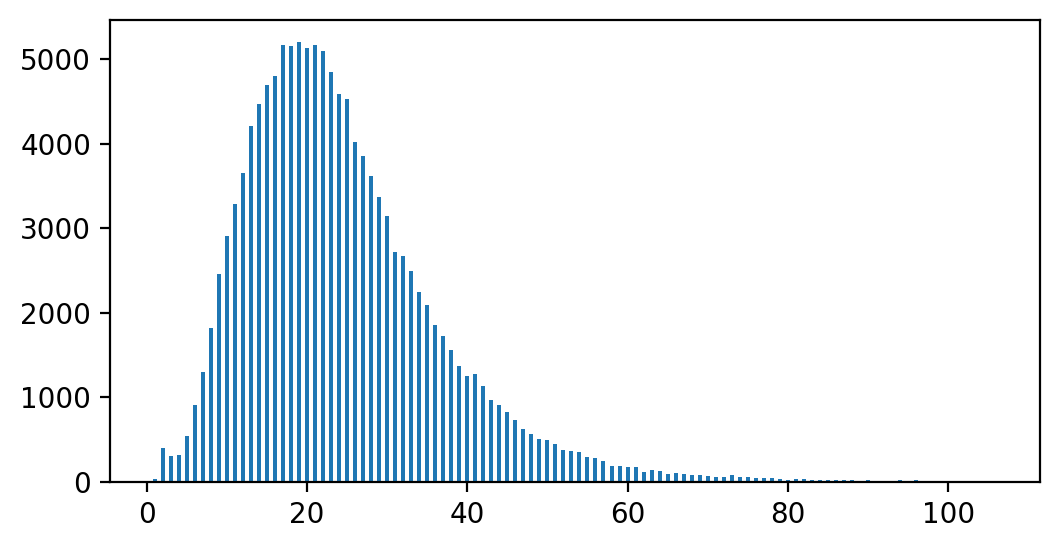

In [28]:
word_vc = tr_titles['words'].transform(lambda x: len(x)).value_counts()[:100]

plt.figure(figsize=(6,3))
plt.bar(word_vc.index, word_vc.values, width=0.5);

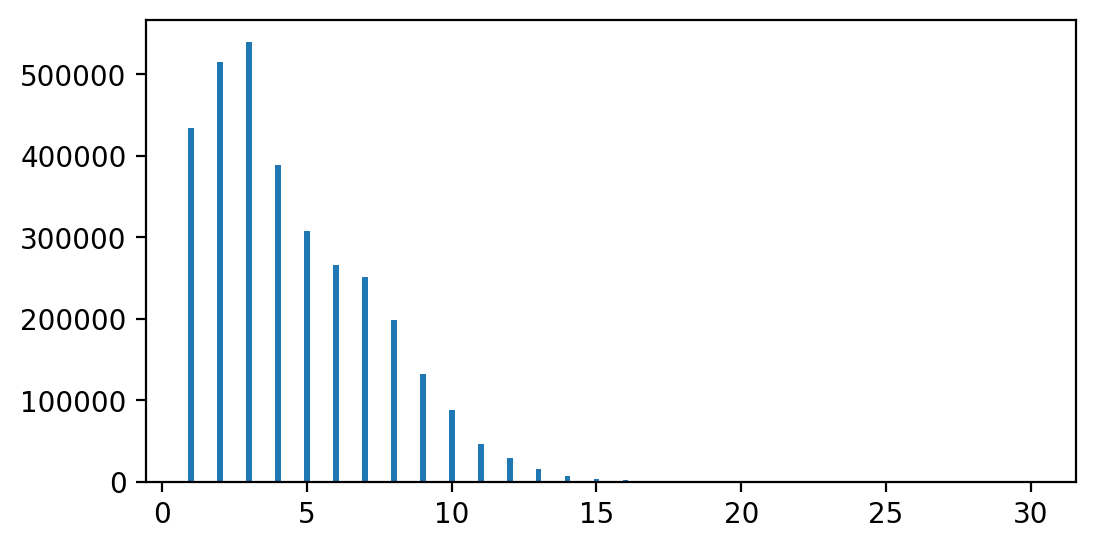

In [29]:
char_vc = tr_titles[['words']].explode('words')['words'].transform(lambda x: len(x)).value_counts()[:30]

plt.figure(figsize=(6,3))
plt.bar(char_vc.index, char_vc.values, width=0.2);

# Prepare data

In [6]:
# tag -> tagID
TAG2IDX = load_json('ner_tags/ner_fine_grained.json')
IDX2TAG = {i: t for t, i in TAG2IDX.items()}

# word -> wordID
WORD2IDX = make_word_vocab(filepath=config.TR_PATH, support=config.WORD_SUPPORT, save_path='tokenizers/word2idx.json')
IDX2WORD = {i: w for w, i in WORD2IDX.items()}

# char -> charID
CHAR2IDX = make_char_vocab(filepath=config.TR_PATH, support=config.CHAR_SUPPORT, save_path='tokenizers/char2idx.json')

In [7]:
# apply TAG2IDX
tr_titles['tag_ids'] = tr_titles['tags_fine_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])
va_titles['tag_ids'] = va_titles['tags_fine_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])

# apply WORD2IDX
tr_titles['word_ids'] = tr_titles['words'].transform(lambda x: [WORD2IDX[w] if w in WORD2IDX else WORD2IDX['UKN'] for w in x])
va_titles['word_ids'] = va_titles['words'].transform(lambda x: [WORD2IDX[w] if w in WORD2IDX else WORD2IDX['UKN'] for w in x])

# apply padding
tr_titles['word_ids'] = tr_titles['word_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)
tr_titles['tag_ids'] = tr_titles['tag_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)

va_titles['word_ids'] = va_titles['word_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)
va_titles['tag_ids'] = va_titles['tag_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)

In [8]:
tr_titles

,id,words,tags_fine_grained,tags_coarse_grained,tag_ids,word_ids
0,0,"[Paul, International, airport, .]","[O, O, O, O]","[O, O, O, O]","[1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[586, 170, 711, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[It, starred, Hicks, 's, wife, ,, Ellaline, Te...","[O, O, person-artist/author, O, O, O, person-a...","[O, O, person, O, O, O, person, person, O, per...","[1, 1, 52, 1, 1, 1, 51, 51, 1, 51, 51, 1, 0, 0...","[35, 1601, 15202, 22, 659, 3, 1, 1, 6, 5586, 8..."
2,2,"[``, Time, ``, magazine, said, the, film, was,...","[O, art-writtenart, O, O, O, O, O, O, O, O, O,...","[O, art, O, O, O, O, O, O, O, O, O, O, O, O, O...","[1, 7, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[10, 2065, 10, 1045, 381, 2, 76, 11, 10, 9, 1,..."
3,3,"[Pakistani, scientists, and, engineers, ', wor...","[O, O, O, O, O, O, O, organization-other, O, O...","[O, O, O, O, O, O, O, organization, O, O, O, O...","[1, 1, 1, 1, 1, 1, 1, 33, 1, 1, 1, 1, 1, 1, 1,...","[5323, 5587, 6, 6537, 59, 603, 21, 1, 78, 1076..."
4,4,"[In, February, 2008, ,, Church, 's, Chicken, e...","[O, O, O, O, organization-company, organizatio...","[O, O, O, O, organization, organization, organ...","[1, 1, 1, 1, 29, 29, 29, 1, 1, 1, 1, 1, 1, 1, ...","[25, 187, 139, 3, 340, 22, 6282, 922, 2, 541, ..."
...,...,...,...,...,...,...
131762,131762,"[In, response, ,, the, states, who, had, ratif...","[O, O, O, O, O, O, O, O, O, other-law, O, O, o...","[O, O, O, O, O, O, O, O, O, other, O, O, organ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 48, 1, 1, 33, 33, ...","[25, 1235, 3, 2, 1110, 49, 40, 8312, 2, 14192,..."
131763,131763,"[They, have, long, been, used, as, containers,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[198, 53, 470, 47, 68, 17, 19121, 16, 8367, 38..."
131764,131764,"[In, 1911, he, came, into, possession, of, the...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[25, 2509, 29, 383, 57, 5299, 5, 2, 1, 1, 1486..."
131765,131765,"[The, Lutici, tribes, in, 983, formed, the, Li...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[12, 1, 3938, 7, 1, 391, 2, 1, 17656, 3, 5239,..."


In [9]:
tr_titles.loc[37661]

id                                                                 37661
words                  [The, Amsterdam, Science, Park, railway, stati...
tags_fine_grained      [O, location-park, location-park, location-par...
tags_coarse_grained    [O, location, location, location, O, O, O, O, ...
tag_ids                [1, 27, 27, 27, 1, 1, 1, 1, 1, 1, 26, 26, 26, ...
word_ids               [12, 2933, 729, 175, 631, 186, 2349, 2, 160, 8...
Name: 37661, dtype: object

# Data loader

In [10]:
tr_dataset = NERDataset(data=tr_titles, idx2word=IDX2WORD, char2idx=CHAR2IDX, max_word_len=config.MAX_WORD_LEN)
va_dataset = NERDataset(data=va_titles, idx2word=IDX2WORD, char2idx=CHAR2IDX, max_word_len=config.MAX_WORD_LEN)

tr_dataloader = DataLoader(dataset=tr_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)
va_dataloader = DataLoader(dataset=va_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=4)

100%|██████████| 18824/18824 [00:04<00:00, 4372.69it/s]


In [11]:
tr_dataset.__getitem__(1)

{'word_ids': tensor([   35,  1601, 15202,    22,   659,     3,     1,     1,     6,  5586,
          8024,     4,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'char_ids': tensor([[37,  4,  0,  ...,  0,  0,  0],
         [ 9,  4,  3,  ...,  0,  0,  0],
         [40,  6, 13,  ...,  0,  0,  0],
         ...,
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0]]),
 'tag_ids': tensor([ 1,  1, 52,  1,  1,  1, 51, 51,  1, 51, 51,  1,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,

In [12]:
for data in tr_dataloader:
    break

In [13]:
data['word_ids'].size(), data['char_ids'].size(), data['tag_ids'].size()

(torch.Size([128, 64]), torch.Size([128, 64, 16]), torch.Size([128, 64]))

# Model

In [18]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = CNN_BiRNN_CRF(
    word_embed_size  = config.WORD_EMBED_SIZE,
    char_embed_size  = config.CHAR_EMBED_SIZE,
    char_kernel_size = config.CHAR_KERNEL_SIZE,
    rnn_cell         = config.RNN_CELL,
    rnn_hidden_size  = config.RNN_HIDDEN_SIZE,
    dropout          = config.DROPOUT,
    num_layers       = config.NUM_LAYERS,
    skip_connection  = config.SKIP_CONNECTION,
    word_voc_size    = len(WORD2IDX),
    char_voc_size    = len(CHAR2IDX),
    tag_voc_size     = len(TAG2IDX),
).to(device)
print(model)

word_embedding.weight                    initialized w with Xavier            parameters #: 2530304
char_embedding.char_embedding.weight     initialized w with Xavier            parameters #: 15488
char_embedding.char_conv.weight          initialized w with Xavier            parameters #: 49152
char_embedding.char_conv.bias            initialized b with zero              parameters #: 128
rnn.weight_ih_l0                         initialized w with Xavier            parameters #: 49152
rnn.weight_hh_l0                         initialized w with Xavier            parameters #: 12288
rnn.bias_ih_l0                           initialized b with zero              parameters #: 192
rnn.bias_hh_l0                           initialized b with zero              parameters #: 192
rnn.weight_ih_l0_reverse                 initialized w with Xavier            parameters #: 49152
rnn.weight_hh_l0_reverse                 initialized w with Xavier            parameters #: 12288
rnn.bias_ih_l0_reverse  

# Train

In [ ]:
weights_folder = 'weights'
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
    
runs_folder = 'runs'
if not os.path.exists(runs_folder):
    os.makedirs(runs_folder)

experiment_folder = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
if not os.path.exists(f'{runs_folder}/{experiment_folder}'):
    os.makedirs(f'{runs_folder}/{experiment_folder}')

In [18]:
# Make optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.LR)

# Make tensorboard writer
writer = tensorboard.SummaryWriter(log_dir=f'{runs_folder}/{experiment_folder}')
writer.add_text('Parameters', " ".join([f"{k}={v}" for k,v in config.__dict__.items()]))

for epoch in range(config.NUM_EPOCHS):
    print(f'EPOCH: {epoch}')

    # TRAINING PHASE
    
    tr_losses = []
    
    model.train()
    for batch_id, tr_batch in enumerate(tr_dataloader):
        optimizer.zero_grad()
        
        tr_xs = tr_batch['word_ids'].to(device) # [batch_size, max_seq_len]
        tr_cs = tr_batch['char_ids'].to(device) # [batch_size, max_seq_len, max_word_len]
        tr_ys = tr_batch['tag_ids'].to(device) # [batch_size, max_seq_len]
        tr_mask = (tr_ys > 0).bool()
        
        # Calculate NLL loss
        tr_emission_scores = model(word_ids=tr_xs, char_ids=tr_cs).to(device) # [batch_size, max_seq_len, max_word_len]
        tr_loss = model.loss_fn(emission_scores=tr_emission_scores, tags=tr_ys, mask=tr_mask)
        tr_losses.append(tr_loss.item())
        
        # Calculate loss with regularizarion
        reg_loss = model.regularization_loss_fn(lam=config.REG_LAMBDA)
        total_loss = tr_loss + reg_loss
        
        if batch_id % 100 == 0:
            print(
                f"epoch={epoch:02d}",
                f"batch_id={batch_id:04d}/{len(tr_dataloader)}",
                f"nll_loss={tr_loss:.2f}",
                f"reg_loss={reg_loss:.2f}",
                f"total_loss={total_loss:.2f}"
            )

        # Backward pass: compute gradient of the loss w.r.t. all learnable parameters
        total_loss.backward()
        
        # Clip computed gradients
#         for name, p in model.named_parameters():
#             if name in ["rnn.weight_hh_l0", "rnn.weight_hh_l0_reverse"]:
#                 torch.nn.utils.clip_grad_norm_(parameters=p, max_norm=config.MAX_GRAD_NORM)
        for name, p in model.named_parameters():
            torch.nn.utils.clip_grad_value_(model.parameters(), config.MAX_GRAD_VALUE)


        # Optimize: update the weights using Adam optimizer
        optimizer.step()

    # VALIDATION PHASE
    
    va_losses = []
    
    batch_preds = []
    batch_trues = []

    model.eval()
    with torch.no_grad():
        for va_batch in tqdm(va_dataloader, total=va_dataloader.__len__()):
            
            va_xs = va_batch['word_ids'].to(device) # [batch_size, max_seq_len]
            va_cs = va_batch['char_ids'].to(device) # [batch_size, max_seq_len, max_word_len]
            va_ys = va_batch['tag_ids'].to(device) # [batch_size, max_seq_len]
            va_mask = (va_ys > 0).bool()

            va_emission_scores = model(word_ids=va_xs, char_ids=va_cs).to(device) # [batch_size, max_seq_len]
            va_loss = model.loss_fn(emission_scores=va_emission_scores, tags=va_ys, mask=va_mask)
            va_losses.append(va_loss.item())

            for row_id, true in enumerate(va_ys):
                # do not count padding
                true_tags = true[va_mask[row_id]]
                # idx2tag
                true_tags = [IDX2TAG[idx] for idx in true_tags.tolist()]
                # convert to the format expected by seqeval
                true_tags = io2bio(true_tags)
                batch_trues.append(true_tags)
            
            va_preds = torch.tensor(model.decode(va_emission_scores)).to(device)
            for row_id, pred in enumerate(va_preds):
                # do not count padding
                pred_tags = pred[va_mask[row_id]]
                # idx2tag
                pred_tags = [IDX2TAG[idx] for idx in pred_tags.tolist()]
                # convert to the format expected by seqeval
                pred_tags = io2bio(pred_tags)
                batch_preds.append(pred_tags)
        
#         for i in range(5):
#             print('pred:', batch_preds[i])
#             print('true:', batch_trues[i])
#             print()

    writer.add_scalar('tr/'+'loss', np.mean(tr_losses), global_step=epoch)
    writer.add_scalar('va/'+'loss', np.mean(va_losses), global_step=epoch)
    for name, param in model.named_parameters():
        writer.add_histogram('tr/' + name + '_weight', param.data, global_step=epoch)
        writer.add_histogram('tr/' + name + '_grad', param.grad, global_step=epoch)
    
    print(
        f"tr_avg_loss={np.mean(tr_losses)}", 
        f"va_avg_loss={np.mean(va_losses)}"
    )
    
    report = classification_report(y_true=batch_trues, y_pred=batch_preds, zero_division=0)
    print(report)

    torch.save(model.state_dict(), f"{weights_folder}/model_epoch_{epoch:02d}.pt")

writer.close()

In [27]:
!tensorboard --logdir=runs

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.15.1 at http://localhost:6006/ (Press CTRL+C to quit)
^C
